from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [30]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

noise_dim = 128

dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


Number of examples: 60000
Shape of the images in the dataset: (28, 28)


# D 정의

In [31]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 28x28 영상을 32x32로 만드릭 위해 padding 한다.
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 32, 32, 1)   0           ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 64)   1664        ['zero_padding2d_3[0][0]']       
                                                                                                  
 leaky_re_lu_15 (LeakyReLU)     multiple             0           ['conv2d_21[0][0]',  

# G 정의


In [32]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    x = upsample_block(x,   1, activation=Activation("tanh"))
    # 생성된 이미지 32x32를 28x28로 만들기 위해 cropping한다.
    x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 4096)         524288      ['input_8[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 4096)        16384       ['dense_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 4096)         0           ['batch_normalization_12[

# WGAN-GP 모델 정의

In [33]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [34]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].numpy().squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
118/118 [==============================] - ETA: 0s - d_loss: -7.7371 - g_loss: -17.2484epoch 0


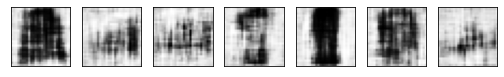

118/118 [==============================] - 70s 330ms/step - d_loss: -7.7340 - g_loss: -17.2319
Epoch 2/100
118/118 [==============================] - ETA: 0s - d_loss: -7.1297 - g_loss: -9.6029epoch 1


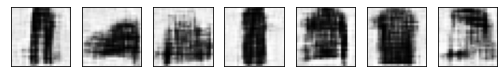

118/118 [==============================] - 39s 331ms/step - d_loss: -7.1280 - g_loss: -9.6190
Epoch 3/100
118/118 [==============================] - ETA: 0s - d_loss: -6.3976 - g_loss: -3.4181epoch 2


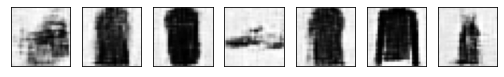

118/118 [==============================] - 38s 325ms/step - d_loss: -6.3972 - g_loss: -3.3964
Epoch 4/100
118/118 [==============================] - ETA: 0s - d_loss: -5.6583 - g_loss: 3.3469epoch 3


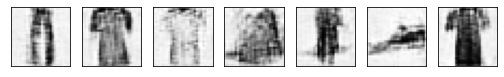

118/118 [==============================] - 38s 326ms/step - d_loss: -5.6552 - g_loss: 3.3767
Epoch 5/100
118/118 [==============================] - ETA: 0s - d_loss: -5.1599 - g_loss: 5.8504epoch 4


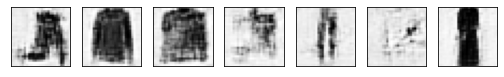

118/118 [==============================] - 39s 328ms/step - d_loss: -5.1679 - g_loss: 5.8957
Epoch 6/100
118/118 [==============================] - ETA: 0s - d_loss: -4.7776 - g_loss: 8.1755epoch 5


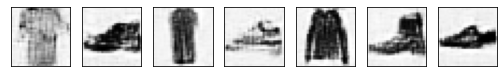

118/118 [==============================] - 38s 326ms/step - d_loss: -4.7777 - g_loss: 8.1658
Epoch 7/100
118/118 [==============================] - ETA: 0s - d_loss: -4.4548 - g_loss: 8.3477epoch 6


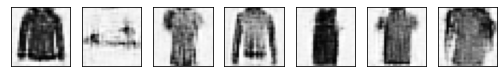

118/118 [==============================] - 38s 326ms/step - d_loss: -4.4606 - g_loss: 8.3464
Epoch 8/100
118/118 [==============================] - ETA: 0s - d_loss: -4.1789 - g_loss: 7.8062epoch 7


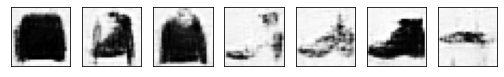

118/118 [==============================] - 39s 329ms/step - d_loss: -4.1901 - g_loss: 7.7851
Epoch 9/100
118/118 [==============================] - ETA: 0s - d_loss: -3.9758 - g_loss: 9.0761epoch 8


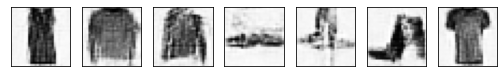

118/118 [==============================] - 39s 331ms/step - d_loss: -3.9697 - g_loss: 9.0758
Epoch 10/100
118/118 [==============================] - ETA: 0s - d_loss: -3.8012 - g_loss: 8.3960epoch 9


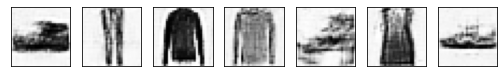

118/118 [==============================] - 40s 341ms/step - d_loss: -3.8068 - g_loss: 8.3797
Epoch 11/100
118/118 [==============================] - ETA: 0s - d_loss: -3.4966 - g_loss: 8.0235epoch 10


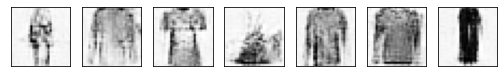

118/118 [==============================] - 39s 333ms/step - d_loss: -3.5000 - g_loss: 7.9995
Epoch 12/100
118/118 [==============================] - ETA: 0s - d_loss: -3.3587 - g_loss: 7.6607epoch 11


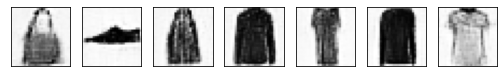

118/118 [==============================] - 40s 338ms/step - d_loss: -3.3692 - g_loss: 7.6689
Epoch 13/100
118/118 [==============================] - ETA: 0s - d_loss: -3.1565 - g_loss: 8.2263epoch 12


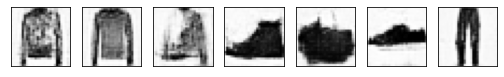

118/118 [==============================] - 40s 342ms/step - d_loss: -3.1455 - g_loss: 8.1924
Epoch 14/100
118/118 [==============================] - ETA: 0s - d_loss: -3.0059 - g_loss: 9.8014epoch 13


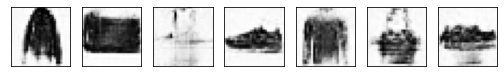

118/118 [==============================] - 40s 336ms/step - d_loss: -2.9994 - g_loss: 9.8289
Epoch 15/100
118/118 [==============================] - ETA: 0s - d_loss: -2.8936 - g_loss: 9.0878epoch 14


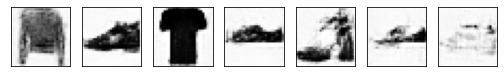

118/118 [==============================] - 40s 339ms/step - d_loss: -2.9045 - g_loss: 9.1154
Epoch 16/100
118/118 [==============================] - ETA: 0s - d_loss: -2.8011 - g_loss: 9.5095epoch 15


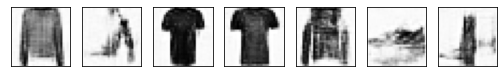

118/118 [==============================] - 39s 328ms/step - d_loss: -2.8047 - g_loss: 9.5382
Epoch 17/100
118/118 [==============================] - ETA: 0s - d_loss: -2.7208 - g_loss: 9.7856epoch 16


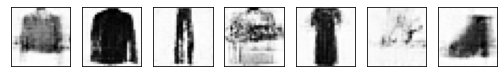

118/118 [==============================] - 39s 330ms/step - d_loss: -2.7226 - g_loss: 9.8065
Epoch 18/100
118/118 [==============================] - ETA: 0s - d_loss: -2.5990 - g_loss: 10.8660epoch 17


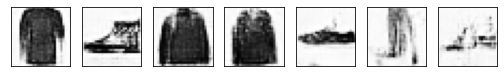

118/118 [==============================] - 40s 335ms/step - d_loss: -2.6090 - g_loss: 10.8690
Epoch 19/100
118/118 [==============================] - ETA: 0s - d_loss: -2.5755 - g_loss: 10.8397epoch 18


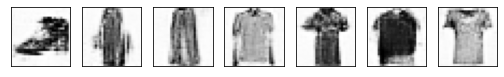

118/118 [==============================] - 39s 328ms/step - d_loss: -2.5785 - g_loss: 10.8268
Epoch 20/100
118/118 [==============================] - ETA: 0s - d_loss: -2.4852 - g_loss: 6.5487epoch 19


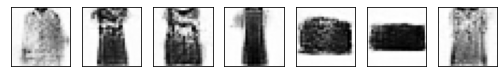

118/118 [==============================] - 39s 328ms/step - d_loss: -2.4995 - g_loss: 6.5615
Epoch 21/100
118/118 [==============================] - ETA: 0s - d_loss: -2.4470 - g_loss: 8.5872epoch 20


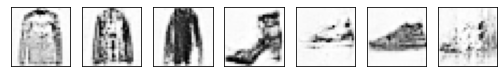

118/118 [==============================] - 39s 328ms/step - d_loss: -2.4437 - g_loss: 8.6065
Epoch 22/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3510 - g_loss: 11.4039epoch 21


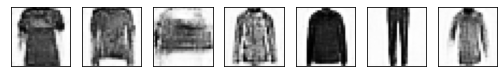

118/118 [==============================] - 39s 330ms/step - d_loss: -2.3477 - g_loss: 11.4424
Epoch 23/100
118/118 [==============================] - ETA: 0s - d_loss: -2.3018 - g_loss: 12.7548epoch 22


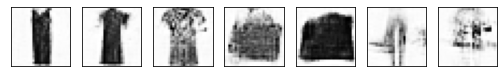

118/118 [==============================] - 39s 331ms/step - d_loss: -2.3231 - g_loss: 12.7626
Epoch 24/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1466 - g_loss: 11.3248epoch 23


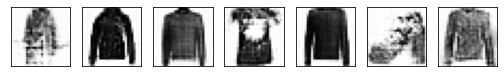

118/118 [==============================] - 39s 327ms/step - d_loss: -2.1442 - g_loss: 11.3508
Epoch 25/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1479 - g_loss: 12.7276epoch 24


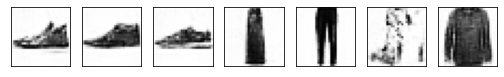

118/118 [==============================] - 39s 328ms/step - d_loss: -2.1387 - g_loss: 12.7569
Epoch 26/100
118/118 [==============================] - ETA: 0s - d_loss: -2.2208 - g_loss: 9.5352epoch 25


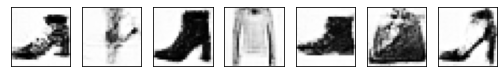

118/118 [==============================] - 39s 328ms/step - d_loss: -2.2362 - g_loss: 9.5089
Epoch 27/100
118/118 [==============================] - ETA: 0s - d_loss: -2.2361 - g_loss: 10.6852epoch 26


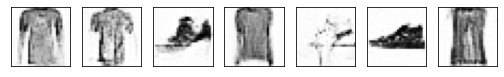

118/118 [==============================] - 39s 328ms/step - d_loss: -2.2517 - g_loss: 10.7366
Epoch 28/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1071 - g_loss: 11.3377epoch 27


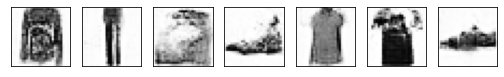

118/118 [==============================] - 39s 328ms/step - d_loss: -2.1102 - g_loss: 11.3541
Epoch 29/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0653 - g_loss: 9.7178epoch 28


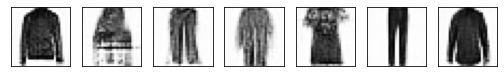

118/118 [==============================] - 39s 328ms/step - d_loss: -2.0699 - g_loss: 9.6938
Epoch 30/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9900 - g_loss: 8.6033epoch 29


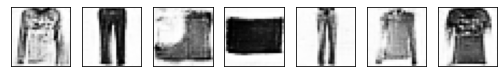

118/118 [==============================] - 39s 328ms/step - d_loss: -1.9936 - g_loss: 8.6002
Epoch 31/100
118/118 [==============================] - ETA: 0s - d_loss: -2.1246 - g_loss: 9.5098epoch 30


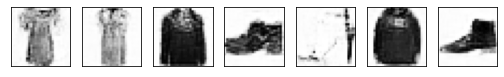

118/118 [==============================] - 39s 328ms/step - d_loss: -2.1568 - g_loss: 9.4646
Epoch 32/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8720 - g_loss: 8.6073epoch 31


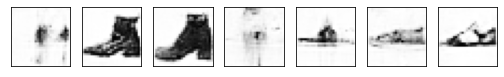

118/118 [==============================] - 39s 330ms/step - d_loss: -1.8684 - g_loss: 8.6114
Epoch 33/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9596 - g_loss: 9.3198epoch 32


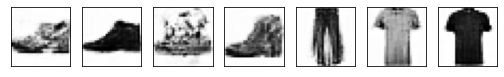

118/118 [==============================] - 39s 328ms/step - d_loss: -1.9576 - g_loss: 9.2842
Epoch 34/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9272 - g_loss: 8.0685epoch 33


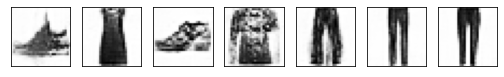

118/118 [==============================] - 39s 329ms/step - d_loss: -1.9465 - g_loss: 8.0640
Epoch 35/100
118/118 [==============================] - ETA: 0s - d_loss: -2.0346 - g_loss: 8.6960epoch 34


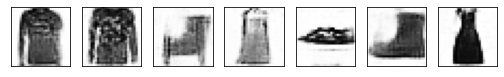

118/118 [==============================] - 39s 329ms/step - d_loss: -2.0411 - g_loss: 8.6340
Epoch 36/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8371 - g_loss: 3.6509epoch 35


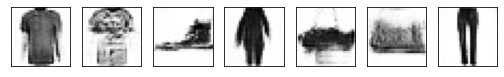

118/118 [==============================] - 39s 329ms/step - d_loss: -1.8429 - g_loss: 3.6832
Epoch 37/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9703 - g_loss: 8.3615epoch 36


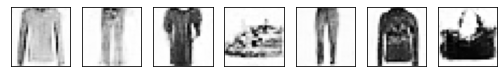

118/118 [==============================] - 39s 328ms/step - d_loss: -1.9690 - g_loss: 8.3220
Epoch 38/100
118/118 [==============================] - ETA: 0s - d_loss: -1.9940 - g_loss: 5.2909epoch 37


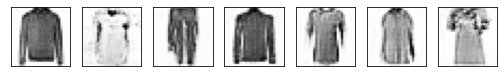

118/118 [==============================] - 39s 328ms/step - d_loss: -2.0074 - g_loss: 5.2777
Epoch 39/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6778 - g_loss: 5.0705epoch 38


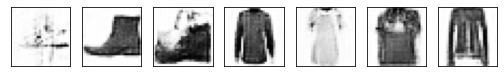

118/118 [==============================] - 39s 328ms/step - d_loss: -1.6536 - g_loss: 5.0676
Epoch 40/100
118/118 [==============================] - ETA: 0s - d_loss: -1.8153 - g_loss: 6.7819epoch 39


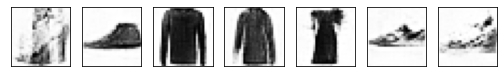

118/118 [==============================] - 39s 327ms/step - d_loss: -1.8119 - g_loss: 6.7607
Epoch 41/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7593 - g_loss: 7.6070epoch 40


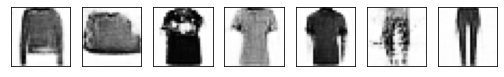

118/118 [==============================] - 39s 330ms/step - d_loss: -1.7609 - g_loss: 7.5925
Epoch 42/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6673 - g_loss: 7.8131epoch 41


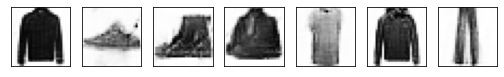

118/118 [==============================] - 39s 328ms/step - d_loss: -1.6531 - g_loss: 7.7887
Epoch 43/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7175 - g_loss: 4.7541epoch 42


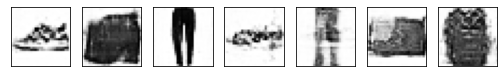

118/118 [==============================] - 39s 328ms/step - d_loss: -1.7187 - g_loss: 4.7653
Epoch 44/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7086 - g_loss: 4.6986epoch 43


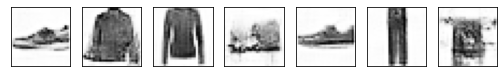

118/118 [==============================] - 39s 329ms/step - d_loss: -1.6973 - g_loss: 4.6870
Epoch 45/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7048 - g_loss: 0.8238epoch 44


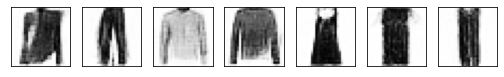

118/118 [==============================] - 39s 329ms/step - d_loss: -1.7053 - g_loss: 0.8949
Epoch 46/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7839 - g_loss: 3.5092epoch 45


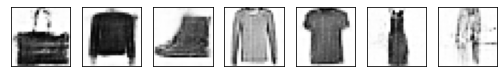

118/118 [==============================] - 39s 329ms/step - d_loss: -1.7983 - g_loss: 3.5235
Epoch 47/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6930 - g_loss: 3.4513epoch 46


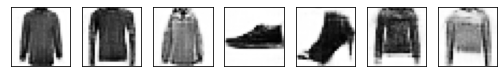

118/118 [==============================] - 39s 328ms/step - d_loss: -1.6972 - g_loss: 3.4815
Epoch 48/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7893 - g_loss: 2.3877epoch 47


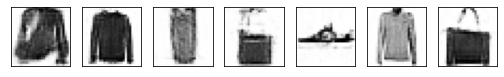

118/118 [==============================] - 39s 330ms/step - d_loss: -1.7935 - g_loss: 2.3878
Epoch 49/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6650 - g_loss: 2.0466epoch 48


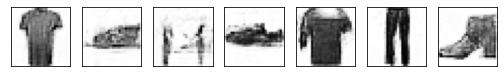

118/118 [==============================] - 39s 328ms/step - d_loss: -1.6731 - g_loss: 2.0649
Epoch 50/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7106 - g_loss: 3.9540epoch 49


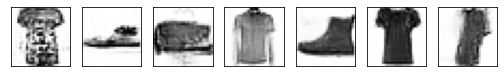

118/118 [==============================] - 39s 331ms/step - d_loss: -1.7203 - g_loss: 3.9576
Epoch 51/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5817 - g_loss: 4.4671epoch 50


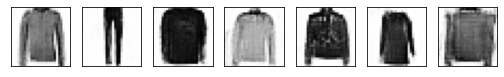

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5809 - g_loss: 4.4583
Epoch 52/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6699 - g_loss: 7.2970epoch 51


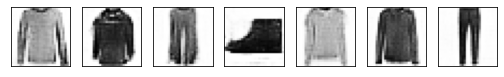

118/118 [==============================] - 39s 330ms/step - d_loss: -1.7010 - g_loss: 7.2954
Epoch 53/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5464 - g_loss: 6.6414epoch 52


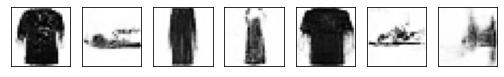

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5603 - g_loss: 6.6525
Epoch 54/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5386 - g_loss: 6.1939epoch 53


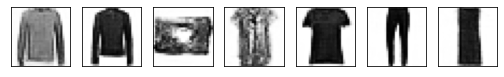

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5409 - g_loss: 6.2211
Epoch 55/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6429 - g_loss: 6.4126epoch 54


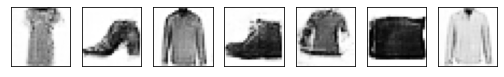

118/118 [==============================] - 39s 329ms/step - d_loss: -1.6663 - g_loss: 6.3885
Epoch 56/100
118/118 [==============================] - ETA: 0s - d_loss: -1.7006 - g_loss: 4.4614epoch 55


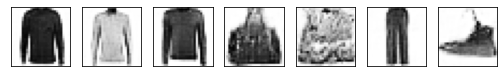

118/118 [==============================] - 39s 330ms/step - d_loss: -1.7004 - g_loss: 4.4125
Epoch 57/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5332 - g_loss: 5.1684epoch 56


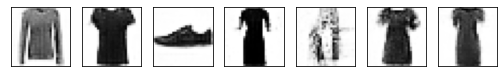

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5262 - g_loss: 5.1784
Epoch 58/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5288 - g_loss: 6.8889epoch 57


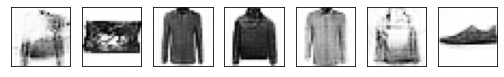

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5226 - g_loss: 6.8514
Epoch 59/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4876 - g_loss: 3.5429epoch 58


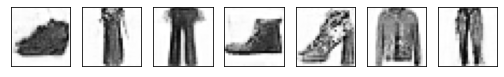

118/118 [==============================] - 39s 331ms/step - d_loss: -1.4805 - g_loss: 3.5596
Epoch 60/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5008 - g_loss: 5.0637epoch 59


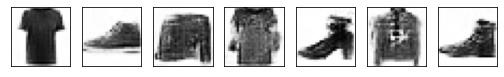

118/118 [==============================] - 39s 330ms/step - d_loss: -1.5105 - g_loss: 5.0221
Epoch 61/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6333 - g_loss: 3.4495epoch 60


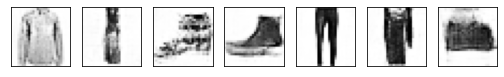

118/118 [==============================] - 39s 329ms/step - d_loss: -1.6488 - g_loss: 3.4322
Epoch 62/100
118/118 [==============================] - ETA: 0s - d_loss: -1.6912 - g_loss: 5.0261epoch 61


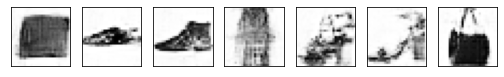

118/118 [==============================] - 39s 329ms/step - d_loss: -1.6930 - g_loss: 5.0230
Epoch 63/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5637 - g_loss: 2.6204epoch 62


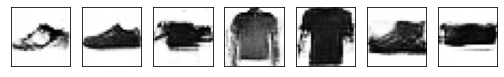

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5748 - g_loss: 2.5897
Epoch 64/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4708 - g_loss: 2.9991epoch 63


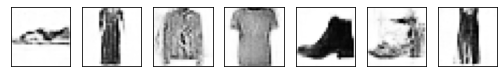

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4721 - g_loss: 3.0006
Epoch 65/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4682 - g_loss: 2.2395epoch 64


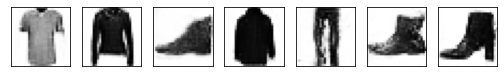

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4694 - g_loss: 2.2335
Epoch 66/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4868 - g_loss: 2.6822epoch 65


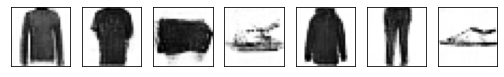

118/118 [==============================] - 39s 328ms/step - d_loss: -1.4835 - g_loss: 2.6719
Epoch 67/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5063 - g_loss: 1.7043epoch 66


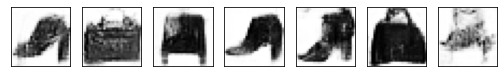

118/118 [==============================] - 39s 330ms/step - d_loss: -1.5006 - g_loss: 1.6786
Epoch 68/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4577 - g_loss: 3.7680epoch 67


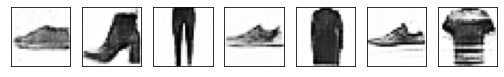

118/118 [==============================] - 39s 330ms/step - d_loss: -1.4621 - g_loss: 3.7522
Epoch 69/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4583 - g_loss: 1.9803epoch 68


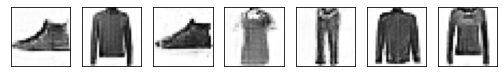

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4702 - g_loss: 1.9884
Epoch 70/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5283 - g_loss: 2.6672epoch 69


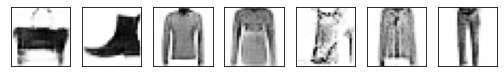

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5227 - g_loss: 2.6556
Epoch 71/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4894 - g_loss: 2.2075epoch 70


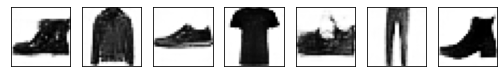

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4905 - g_loss: 2.1738
Epoch 72/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5356 - g_loss: 2.4184epoch 71


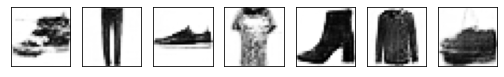

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5470 - g_loss: 2.4248
Epoch 73/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4670 - g_loss: 3.9784epoch 72


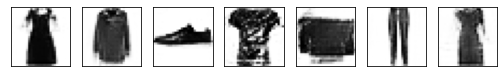

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4776 - g_loss: 4.0238
Epoch 74/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4366 - g_loss: 4.1181epoch 73


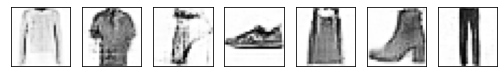

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4389 - g_loss: 4.1332
Epoch 75/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4447 - g_loss: 3.1272epoch 74


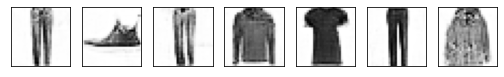

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4453 - g_loss: 3.1592
Epoch 76/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4454 - g_loss: 4.1865epoch 75


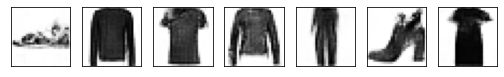

118/118 [==============================] - 39s 330ms/step - d_loss: -1.4192 - g_loss: 4.1865
Epoch 77/100
118/118 [==============================] - ETA: 0s - d_loss: -1.5108 - g_loss: 5.0960epoch 76


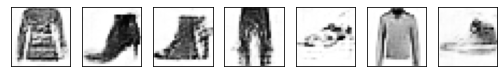

118/118 [==============================] - 39s 332ms/step - d_loss: -1.5202 - g_loss: 5.0728
Epoch 78/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4846 - g_loss: 5.0837epoch 77


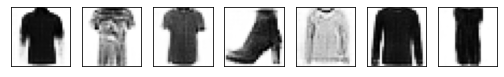

118/118 [==============================] - 39s 329ms/step - d_loss: -1.5017 - g_loss: 5.0632
Epoch 79/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3989 - g_loss: 4.2971epoch 78


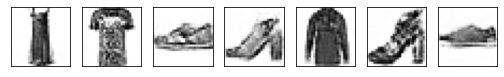

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3884 - g_loss: 4.2687
Epoch 80/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3996 - g_loss: 4.9528epoch 79


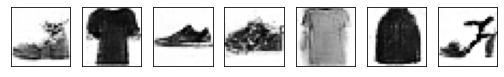

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3932 - g_loss: 4.9845
Epoch 81/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3058 - g_loss: 4.9340epoch 80


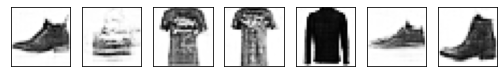

118/118 [==============================] - 39s 328ms/step - d_loss: -1.3028 - g_loss: 4.9321
Epoch 82/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3997 - g_loss: 4.0543epoch 81


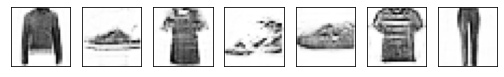

118/118 [==============================] - 39s 328ms/step - d_loss: -1.4026 - g_loss: 4.0270
Epoch 83/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3944 - g_loss: 1.8754epoch 82


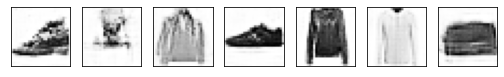

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3901 - g_loss: 1.8785
Epoch 84/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3326 - g_loss: 3.5610epoch 83


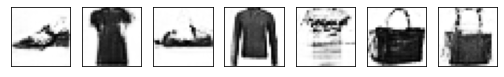

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3377 - g_loss: 3.5698
Epoch 85/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4024 - g_loss: 3.6074epoch 84


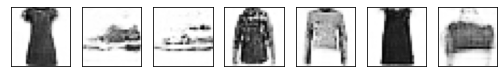

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3928 - g_loss: 3.6022
Epoch 86/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3440 - g_loss: 3.5682epoch 85


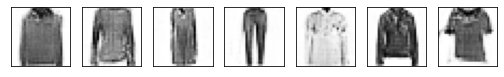

118/118 [==============================] - 39s 331ms/step - d_loss: -1.3355 - g_loss: 3.5811
Epoch 87/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3645 - g_loss: 2.5515epoch 86


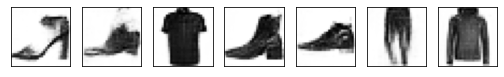

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3636 - g_loss: 2.5541
Epoch 88/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3915 - g_loss: 2.9593epoch 87


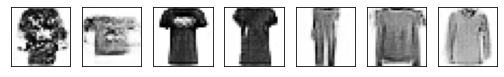

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3891 - g_loss: 2.9392
Epoch 89/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3088 - g_loss: 3.0051epoch 88


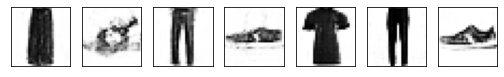

118/118 [==============================] - 39s 328ms/step - d_loss: -1.3025 - g_loss: 3.0273
Epoch 90/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4046 - g_loss: 3.7166epoch 89


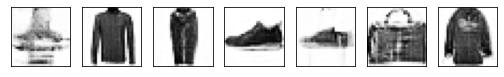

118/118 [==============================] - 39s 330ms/step - d_loss: -1.4309 - g_loss: 3.7632
Epoch 91/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3102 - g_loss: 3.3348epoch 90


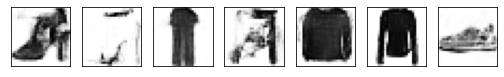

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3197 - g_loss: 3.3474
Epoch 92/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3041 - g_loss: 2.9232epoch 91


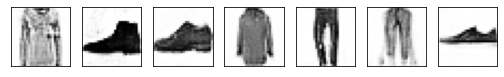

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3081 - g_loss: 2.9495
Epoch 93/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3372 - g_loss: 2.6015epoch 92


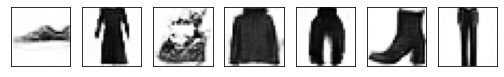

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3241 - g_loss: 2.6101
Epoch 94/100
118/118 [==============================] - ETA: 0s - d_loss: -1.4076 - g_loss: 2.2263epoch 93


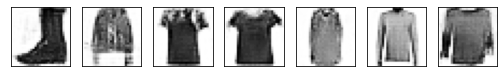

118/118 [==============================] - 39s 329ms/step - d_loss: -1.4193 - g_loss: 2.2573
Epoch 95/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3849 - g_loss: 1.9179epoch 94


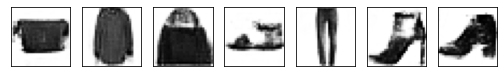

118/118 [==============================] - 39s 332ms/step - d_loss: -1.3812 - g_loss: 1.9595
Epoch 96/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3459 - g_loss: 1.6338epoch 95


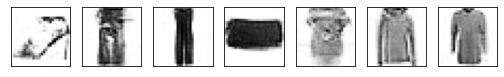

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3504 - g_loss: 1.6132
Epoch 97/100
118/118 [==============================] - ETA: 0s - d_loss: -1.2446 - g_loss: 1.6197epoch 96


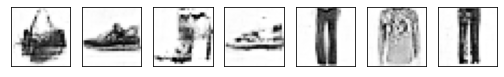

118/118 [==============================] - 39s 329ms/step - d_loss: -1.2587 - g_loss: 1.6575
Epoch 98/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3034 - g_loss: 0.0175epoch 97


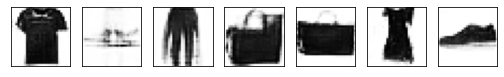

118/118 [==============================] - 39s 330ms/step - d_loss: -1.2970 - g_loss: 0.0017
Epoch 99/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3703 - g_loss: -0.1616epoch 98


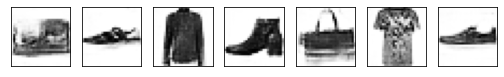

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3800 - g_loss: -0.1504
Epoch 100/100
118/118 [==============================] - ETA: 0s - d_loss: -1.3214 - g_loss: 0.1657epoch 99


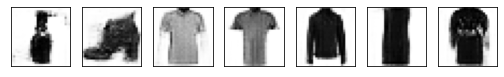

118/118 [==============================] - 39s 329ms/step - d_loss: -1.3266 - g_loss: 0.2102


In [35]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


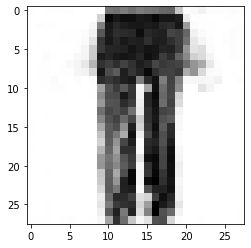

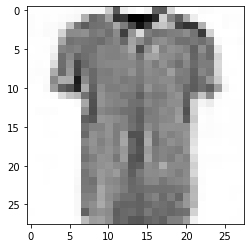

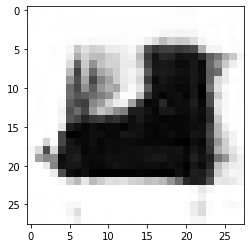

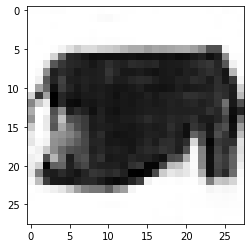

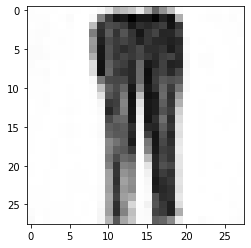

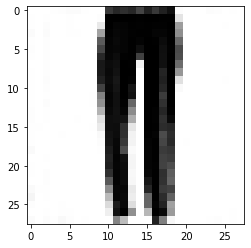

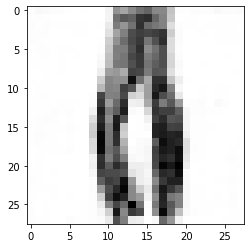

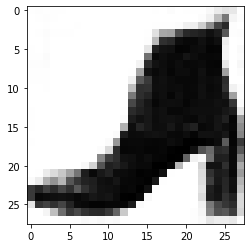

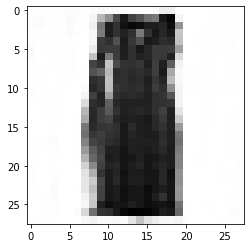

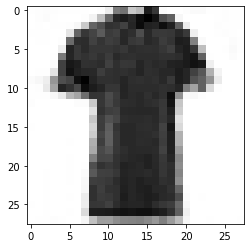

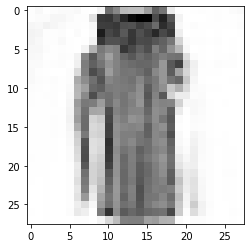

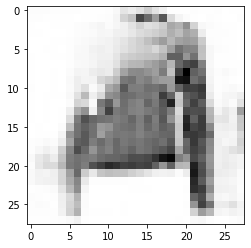

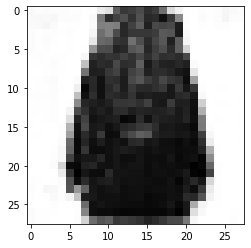

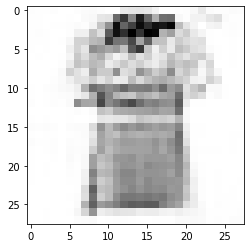

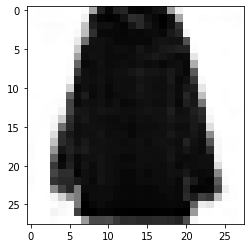

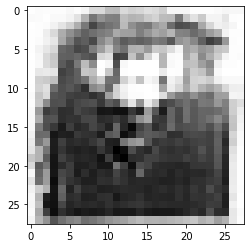

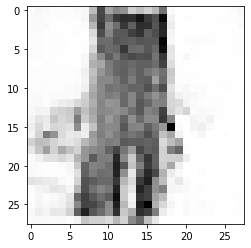

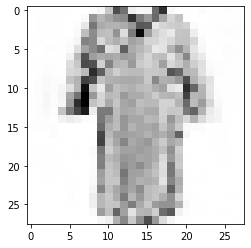

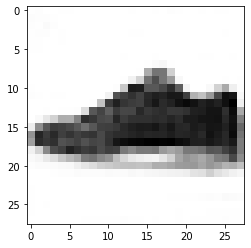

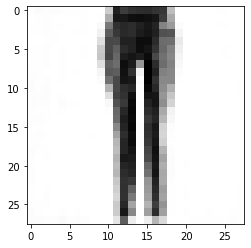

In [36]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(20, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
generated_images = (generated_images * 127.5) + 127.5
for image in generated_images:
  plt.imshow(image.numpy().squeeze(), cmap="binary")
  plt.show()